# The COP Problem: Conditional on Positives

**Chapter 7, Section 4**

This notebook covers why analyzing only "positive" outcomes (engaged users, buyers, responders) leads to biased treatment effect estimates.

## Table of Contents
1. [Intuition](#intuition) - The "engaged users only" trap
2. [Formal Treatment](#formal) - COP decomposition
3. [Numeric Demonstration](#numeric) - Frugal vs rich customers
4. [Implementation](#implementation) - Detecting COP bias
5. [Interview Appendix](#interview) - Practice questions

---

In [1]:
# Standard imports
import sys
sys.path.insert(0, '../..')

from facure_augment.common import *

# Set notebook style
set_notebook_style()

print("Imports complete")

Imports complete


---

## Intuition

### The "Engaged Users Only" Trap

A common (flawed) analysis:

> "Let's compare average purchase amounts between treatment and control, **among users who made a purchase**."

This is called **Conditional on Positives (COP)** analysis. It seems reasonable but introduces severe selection bias.

**Why it fails**: Treatment affects **who** enters the "positive" sample!

**Example**: A coupon (treatment) might cause frugal customers to buy who otherwise wouldn't. Among buyers:
- Treatment group: Mix of frugal + regular buyers
- Control group: Only regular buyers (frugal didn't buy)

The treatment group appears to spend **less** per purchase, even though the coupon worked!

★ Insight ─────────────────────────────────────
- COP analysis conditions on a **post-treatment variable** (purchased)
- Treatment changes the composition of "positive" samples
- This is a special case of mediator/selection bias
- Common mistake in A/B testing and marketing analytics
─────────────────────────────────────────────────

In [2]:
# Simulate the frugal vs rich customer problem
np.random.seed(42)
n = 2000

# Two customer types: Frugal (60%) and Rich (40%)
is_rich = np.random.binomial(1, 0.4, n)

# Random treatment assignment
treatment = np.random.binomial(1, 0.5, n)

# Purchase behavior:
# - Rich customers always buy
# - Frugal customers only buy WITH treatment (coupon)
purchased = np.where(
    is_rich == 1,
    1,  # Rich always buy
    treatment  # Frugal only buy with coupon
)

# Purchase amount (if purchased):
# - Rich spend ~$100
# - Frugal spend ~$30
amount = np.where(
    purchased == 1,
    np.where(is_rich == 1, 100 + np.random.normal(0, 10, n), 30 + np.random.normal(0, 5, n)),
    0
)

sim_data = pd.DataFrame({
    'is_rich': is_rich,
    'treatment': treatment,
    'purchased': purchased,
    'amount': amount
})

print(f"Simulated {n} customers")
print(f"Rich customers: {is_rich.mean():.1%}")
print(f"Overall purchase rate: {purchased.mean():.1%}")

Simulated 2000 customers
Rich customers: 40.8%
Overall purchase rate: 70.0%


In [3]:
# The CORRECT analysis: Total revenue effect
revenue_treatment = sim_data.loc[sim_data['treatment']==1, 'amount'].mean()
revenue_control = sim_data.loc[sim_data['treatment']==0, 'amount'].mean()

print("CORRECT ANALYSIS: Average revenue (all customers)")
print(f"  Treatment: ${revenue_treatment:.2f}")
print(f"  Control:   ${revenue_control:.2f}")
print(f"  Effect:    ${revenue_treatment - revenue_control:.2f} (+{(revenue_treatment/revenue_control - 1)*100:.0f}%)")
print(f"\n→ Treatment INCREASES revenue!")

CORRECT ANALYSIS: Average revenue (all customers)
  Treatment: $58.66
  Control:   $40.25
  Effect:    $18.41 (+46%)

→ Treatment INCREASES revenue!


In [4]:
# The WRONG analysis: COP (among buyers only)
buyers = sim_data[sim_data['purchased'] == 1]

cop_treatment = buyers.loc[buyers['treatment']==1, 'amount'].mean()
cop_control = buyers.loc[buyers['treatment']==0, 'amount'].mean()

print("WRONG ANALYSIS (COP): Average revenue among BUYERS only")
print(f"  Treatment buyers: ${cop_treatment:.2f}")
print(f"  Control buyers:   ${cop_control:.2f}")
print(f"  COP 'effect':     ${cop_treatment - cop_control:.2f} ({(cop_treatment/cop_control - 1)*100:.0f}%)")
print(f"\n→ COP analysis wrongly suggests treatment DECREASES spending!")

WRONG ANALYSIS (COP): Average revenue among BUYERS only
  Treatment buyers: $58.66
  Control buyers:   $99.40
  COP 'effect':     $-40.74 (-41%)

→ COP analysis wrongly suggests treatment DECREASES spending!


---

## Formal Treatment

### The COP Decomposition

Let $Y$ be revenue (with $Y = 0$ for non-buyers). The **total effect** can be decomposed:

$$E[Y | T] = P(Y > 0 | T) \cdot E[Y | Y > 0, T]$$

So the treatment effect on total revenue is:

$$E[Y | T=1] - E[Y | T=0] = \underbrace{\Delta P(Y > 0)}_{\text{Participation effect}} \cdot \bar{Y}_{positive} + \underbrace{\Delta E[Y | Y > 0]}_{\text{COP effect (biased!)}} \cdot \bar{P}_{positive}$$

**The COP component is biased** because:

$$E[Y | Y > 0, T=1] - E[Y | Y > 0, T=0] = \underbrace{\text{True intensive margin effect}}_{\text{(may be zero)}} + \underbrace{\text{Selection bias}}_{\text{(composition change)}}$$

### Selection Bias in COP

$$E[Y_0 | Y > 0, T=1] \neq E[Y_0 | Y > 0, T=0]$$

- Left side: Baseline spending of treatment buyers
- Right side: Baseline spending of control buyers

If treatment brings in **new types of buyers**, these groups have different baseline characteristics.

In [5]:
# Show the composition change
print("Composition of BUYERS by treatment:")
print(f"\nTreatment group buyers:")
t_buyers = buyers[buyers['treatment'] == 1]
print(f"  Rich: {t_buyers['is_rich'].mean():.1%}")
print(f"  Frugal: {1 - t_buyers['is_rich'].mean():.1%}")

print(f"\nControl group buyers:")
c_buyers = buyers[buyers['treatment'] == 0]
print(f"  Rich: {c_buyers['is_rich'].mean():.1%}")
print(f"  Frugal: {1 - c_buyers['is_rich'].mean():.1%}")

print(f"\n→ Treatment brings in frugal buyers who spend less!")
print(f"→ This changes the COMPOSITION of the buyer group")

Composition of BUYERS by treatment:

Treatment group buyers:
  Rich: 41.2%
  Frugal: 58.8%

Control group buyers:
  Rich: 100.0%
  Frugal: 0.0%

→ Treatment brings in frugal buyers who spend less!
→ This changes the COMPOSITION of the buyer group


---

## Numeric Demonstration

### Visualizing the COP Problem

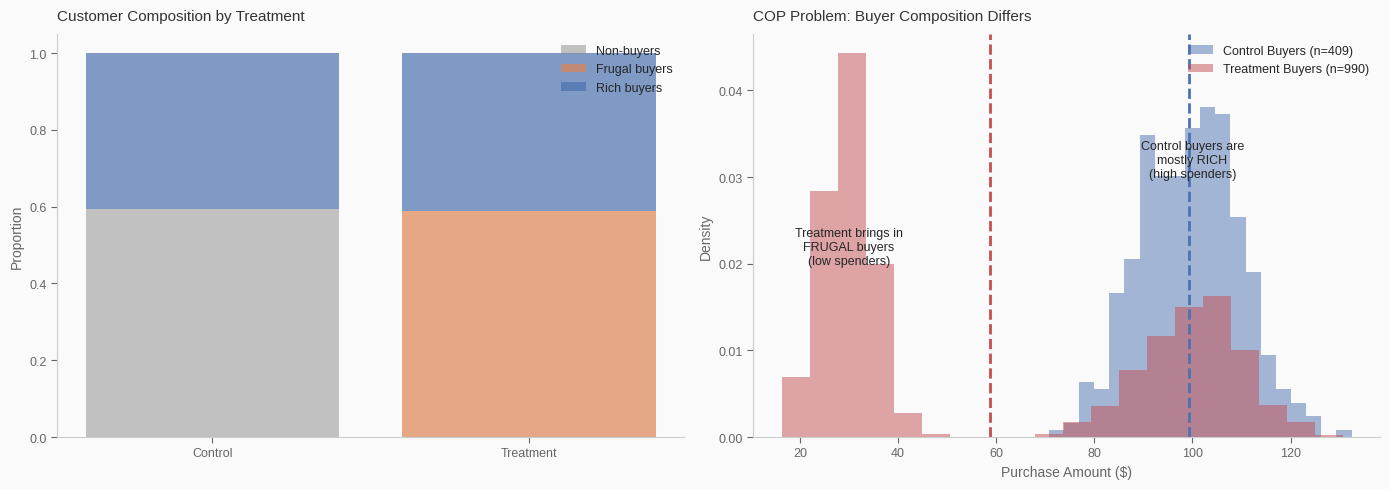

In [6]:
fig, axes = create_tufte_figure(ncols=2, figsize=(14, 5))

# Left: Show all customers (correct view)
ax = axes[0]

# Stacked bar showing purchase rates and amounts
for t_val, x_pos, label in [(0, 0, 'Control'), (1, 1, 'Treatment')]:
    subset = sim_data[sim_data['treatment'] == t_val]
    
    # Non-buyers (bottom)
    non_buyers = (subset['purchased'] == 0).mean()
    
    # Frugal buyers (middle)
    frugal_buyers = ((subset['purchased'] == 1) & (subset['is_rich'] == 0)).mean()
    
    # Rich buyers (top)
    rich_buyers = ((subset['purchased'] == 1) & (subset['is_rich'] == 1)).mean()
    
    ax.bar(x_pos, non_buyers, color=COLORS['gray'], alpha=0.5, label='Non-buyers' if t_val == 0 else '')
    ax.bar(x_pos, frugal_buyers, bottom=non_buyers, color=COLORS['orange'], alpha=0.7, 
           label='Frugal buyers' if t_val == 0 else '')
    ax.bar(x_pos, rich_buyers, bottom=non_buyers + frugal_buyers, color=COLORS['blue'], alpha=0.7,
           label='Rich buyers' if t_val == 0 else '')

ax.set_xticks([0, 1])
ax.set_xticklabels(['Control', 'Treatment'])
ax.legend(loc='upper right', frameon=False)
set_tufte_title(ax, "Customer Composition by Treatment")
set_tufte_labels(ax, "", "Proportion")

# Right: Purchase amounts (showing the COP problem)
ax = axes[1]

# Among buyers only
for t_val, color, label in [(0, COLORS['blue'], 'Control Buyers'), (1, COLORS['red'], 'Treatment Buyers')]:
    subset = buyers[buyers['treatment'] == t_val]
    ax.hist(subset['amount'], bins=20, alpha=0.5, color=color, label=f'{label} (n={len(subset)})', density=True)
    ax.axvline(subset['amount'].mean(), color=color, linestyle='--', linewidth=2)

ax.annotate('Control buyers are\nmostly RICH\n(high spenders)', 
            xy=(100, 0.03), fontsize=9, ha='center')
ax.annotate('Treatment brings in\nFRUGAL buyers\n(low spenders)', 
            xy=(30, 0.02), fontsize=9, ha='center')

set_tufte_title(ax, "COP Problem: Buyer Composition Differs")
set_tufte_labels(ax, "Purchase Amount ($)", "Density")
ax.legend(loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

In [7]:
# Full decomposition
print("REVENUE DECOMPOSITION")
print("=" * 55)

for t_val, label in [(0, 'Control'), (1, 'Treatment')]:
    subset = sim_data[sim_data['treatment'] == t_val]
    
    p_positive = subset['purchased'].mean()
    e_positive = subset.loc[subset['purchased']==1, 'amount'].mean()
    e_total = subset['amount'].mean()
    
    print(f"\n{label}:")
    print(f"  P(purchase) = {p_positive:.2%}")
    print(f"  E[amount | purchase] = ${e_positive:.2f}")
    print(f"  E[amount] = P × E = {p_positive:.2%} × ${e_positive:.2f} = ${e_total:.2f}")

print(f"\nEffects:")
p_t = sim_data.loc[sim_data['treatment']==1, 'purchased'].mean()
p_c = sim_data.loc[sim_data['treatment']==0, 'purchased'].mean()
print(f"  ΔP(purchase) = {p_t - p_c:.2%} (POSITIVE: more people buy!)")
print(f"  ΔE[amount | purchase] = ${cop_treatment - cop_control:.2f} (NEGATIVE: COP bias)")
print(f"  ΔE[amount] (TOTAL) = ${revenue_treatment - revenue_control:.2f} (POSITIVE: correct answer!)")

REVENUE DECOMPOSITION

Control:
  P(purchase) = 40.50%
  E[amount | purchase] = $99.40
  E[amount] = P × E = 40.50% × $99.40 = $40.25

Treatment:
  P(purchase) = 100.00%
  E[amount | purchase] = $58.66
  E[amount] = P × E = 100.00% × $58.66 = $58.66

Effects:
  ΔP(purchase) = 59.50% (POSITIVE: more people buy!)
  ΔE[amount | purchase] = $-40.74 (NEGATIVE: COP bias)
  ΔE[amount] (TOTAL) = $18.41 (POSITIVE: correct answer!)


---

## Implementation

### Detecting COP Bias Risk

In [8]:
def diagnose_cop_bias(data, treatment, outcome, positive_threshold=0):
    """
    Diagnose potential COP bias in an analysis.
    
    Parameters
    ----------
    data : pd.DataFrame
    treatment : str
        Treatment column name.
    outcome : str
        Outcome column name.
    positive_threshold : float
        Value above which outcome is considered "positive".
        
    Returns
    -------
    dict with diagnosis
    """
    # Define positive
    is_positive = data[outcome] > positive_threshold
    
    # Calculate rates
    p_pos_t = is_positive[data[treatment] == 1].mean()
    p_pos_c = is_positive[data[treatment] == 0].mean()
    
    # Calculate conditional means
    e_pos_t = data.loc[(data[treatment] == 1) & is_positive, outcome].mean()
    e_pos_c = data.loc[(data[treatment] == 0) & is_positive, outcome].mean()
    
    # Calculate total means
    e_total_t = data.loc[data[treatment] == 1, outcome].mean()
    e_total_c = data.loc[data[treatment] == 0, outcome].mean()
    
    # Risk assessment
    participation_change = (p_pos_t - p_pos_c) / p_pos_c if p_pos_c > 0 else np.inf
    cop_effect_sign = np.sign(e_pos_t - e_pos_c)
    total_effect_sign = np.sign(e_total_t - e_total_c)
    
    # COP bias likely if signs differ or large participation change
    cop_risk = abs(participation_change) > 0.10 or (cop_effect_sign != total_effect_sign)
    
    return {
        'P(positive|T=1)': p_pos_t,
        'P(positive|T=0)': p_pos_c,
        'participation_change': participation_change,
        'E[Y|positive,T=1]': e_pos_t,
        'E[Y|positive,T=0]': e_pos_c,
        'COP_effect': e_pos_t - e_pos_c,
        'E[Y|T=1]': e_total_t,
        'E[Y|T=0]': e_total_c,
        'total_effect': e_total_t - e_total_c,
        'COP_risk': 'HIGH' if cop_risk else 'LOW',
        'warning': 'COP and total effects have DIFFERENT signs!' if cop_effect_sign != total_effect_sign else 'Signs consistent'
    }

# Apply to simulated data
diagnosis = diagnose_cop_bias(sim_data, 'treatment', 'amount')

print("COP Bias Diagnosis:")
print("=" * 55)
for k, v in diagnosis.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.3f}")
    else:
        print(f"  {k}: {v}")

COP Bias Diagnosis:
  P(positive|T=1): 1.000
  P(positive|T=0): 0.405
  participation_change: 1.469
  E[Y|positive,T=1]: 58.665
  E[Y|positive,T=0]: 99.403
  COP_effect: -40.738
  E[Y|T=1]: 58.665
  E[Y|T=0]: 40.253
  total_effect: 18.411
  COP_risk: HIGH


In [9]:
# Apply to real email data (payments as outcome)
email = load_facure_data("collections_email.csv")

print("\nReal Data: Email Campaign")
print("=" * 55)
diagnosis_email = diagnose_cop_bias(email, 'email', 'payments', positive_threshold=0)

for k, v in diagnosis_email.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.3f}")
    else:
        print(f"  {k}: {v}")


Real Data: Email Campaign
  P(positive|T=1): 1.000
  P(positive|T=0): 1.000
  participation_change: 0.000
  E[Y|positive,T=1]: 669.356
  E[Y|positive,T=0]: 669.976
  COP_effect: -0.620
  E[Y|T=1]: 669.356
  E[Y|T=0]: 669.976
  total_effect: -0.620
  COP_risk: LOW


---

## Interview Appendix

### Practice Questions

**Q1: What's wrong with analyzing "engaged users only"?**

<details>
<summary>Solution</summary>

"Engaged users only" is a **Conditional on Positives (COP)** analysis that introduces selection bias.

**The problem**:
1. Treatment affects WHO becomes "engaged" (selection into sample)
2. Treatment and control "engaged" groups are NOT comparable
3. The composition of engaged users differs by treatment

**Example**: A push notification might engage users who otherwise wouldn't engage. Among engaged users:
- Treatment: Mix of naturally-engaged + notification-activated users
- Control: Only naturally-engaged users

If notification-activated users behave differently (less engaged baseline), the COP analysis is biased.

**Correct approach**: Analyze ALL users, including non-engaged (with zeros or appropriate outcome).

</details>

**Q2: A coupon increases purchases by 20% but COP analysis shows -15% effect on basket size. How do you explain this to stakeholders?**

<details>
<summary>Solution</summary>

**Explanation framework**:

1. **The coupon WORKS**: 20% more customers are purchasing (extensive margin)

2. **COP is misleading**: The -15% on basket size among buyers is because:
   - Coupon attracts **new, price-sensitive buyers**
   - These buyers have smaller basket sizes than regular buyers
   - The composition of "buyers" changed

3. **The right metric is total revenue**:
   - More customers buying (even if smaller baskets) can increase total revenue
   - Show the math: If purchase rate goes from 10% to 12%, and average basket goes from $100 to $85:
     - Control: 0.10 × $100 = $10 per customer
     - Treatment: 0.12 × $85 = $10.20 per customer
     - Still a +2% lift!

4. **Analogy**: "A discount airline has lower customer satisfaction ratings than a luxury airline, but serves 10× more customers profitably."

</details>

**Q3: When is COP analysis appropriate?**

<details>
<summary>Solution</summary>

COP analysis is appropriate when:

1. **The "positive" condition is pre-treatment**:
   - Example: Analyzing existing customers only (not new customer acquisition)
   - The sample is defined BEFORE treatment assignment

2. **Treatment doesn't affect selection into "positive"**:
   - Example: All users in sample will definitely engage (just measuring intensity)
   - No extensive margin effect

3. **You explicitly want the intensive margin effect**:
   - Mediation analysis: Direct effect vs indirect through engagement
   - But use proper methods (principal stratification, bounds)

**Warning signs it's inappropriate**:
- Treatment affects purchase/engagement rates
- Sample sizes differ substantially by treatment
- COP effect has opposite sign from total effect

</details>

---

## References

[^1]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 7.

[^2]: Knox, D., Lowe, W., & Mummolo, J. (2020). Administrative records mask racially biased policing. *American Political Science Review*.

[^3]: Cross-reference: Selection bias in `07_beyond_confounders/03_selection_bias_mediators.ipynb`